In [4]:
#this is a data cleaning jupyter notebook on horse racing data

import pandas as pd
import numpy as np
import regex
import time
import os
import seaborn as sns
%pwd

'/home/neilfa/jupyter_data_cleaning'

In [7]:
with open('/proc/meminfo') as file:
    for line in file:
        if 'MemFree' in line:
            free_mem_in_kb = line.split()[1]
            break
file_path = '2019_1_1-2020_1_1.csv' 
file_size = os.path.getsize(file_path)
            
start = time.time()
df = pd.read_csv(file_path)
end = time.time()
index = df.index
num_row = len(index)

print('It takes {0} seconds to load in {1} rows of data (size of the file is {2} bytes), with {3} memory available'.format((end-start),num_row,file_size,free_mem_in_kb))

It takes 0.1813802719116211 seconds to load in 31651 rows of data (size of the file is 14016826 bytes), with 12307296 memory available


Index(['Date', 'Region', 'Course', 'Off', 'Name', 'Type', 'Class', 'Pattern',
       'Rating_Band', 'Age_Band', 'Sex_Rest', 'Dist', 'Dist_Y', 'Dist_M',
       'Dist_F', 'Going', 'Num', 'Pos', 'Ran', 'Draw', 'Btn', 'Ovr_Btn',
       'Horse', 'SP', 'Dec', 'Age', 'Sex', 'Wgt', 'Lbs', 'HG'],
      dtype='object')


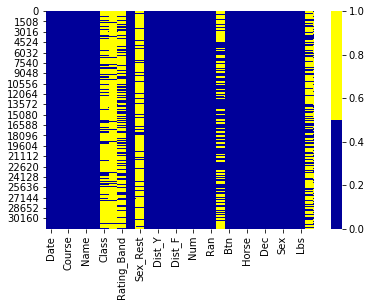

In [17]:
# missing values analysis

cols = df.columns[:30] # first 30
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

#normal for class to have missing values as Ireland races don't have a class




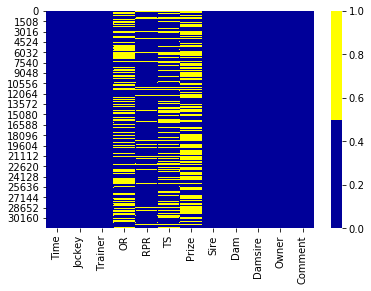

In [129]:

cols = df.columns[30:42] # last 12
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [8]:
# Gonna make a smaller dataframe (sm_df)
# Just to make it easier to work with

sm_df = df.loc[:,('Date','Name','Horse','Pos','SP','Ran','Time','RPR',)]
sm_df.head()

,Date,Name,Horse,Pos,SP,Ran,Time,RPR
0,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,3/1,15,5:1.80,127.0
1,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,8/1,15,5:4.20,111.0
2,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,10/11F,15,5:5.15,115.0
3,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,25/1,15,5:5.40,112.0
4,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,8/1,15,5:5.70,111.0


In [9]:
# sorting out the fractional odds to decimal odds, and having a new column saying if they are favourite
# decimal odds are easier to work with 
# decimal odds = numerator / denominator + 1

fodds = df.loc[:,'SP'] #fractional odds
fodds = fodds.str.replace("Evens","1/1")
fodds = fodds.str.replace("Evs","1/1")
splt = fodds.str.extract(r'(\d+).(\d+)(.?)')

splt.iloc[:,0] = splt.iloc[:,0].astype(float)
splt.iloc[:,1] = splt.iloc[:,1].astype(float)

dodds = (splt.iloc[:,0]/splt.iloc[:,1])+1 #decimal odds

odds_f = pd.concat([dodds,splt.iloc[:,2]],axis=1)

sm_df.loc[:,'SP'] = odds_f.iloc[:,0]
sm_df = pd.concat([sm_df,odds_f.iloc[:,1]],axis=1)


sm_df=sm_df.rename(columns={2:"Fav"})

#There are 3 possible letters that can come after the odds:
#F there is one favourite in the race (7/2F)
#J there are 2 favourite in the race (same odds) (7/2J,7/2J)
#C there are 3 favourite (3/1C,3/1C,3/1C)

#Instead of keeping the letters
#Gonna make a new column with series of bool - favorite TRUE or FALSE

sm_df.loc[:,"Fav"] = sm_df.loc[:,"Fav"].str.contains(r"\S") 

sm_df.head()





,Date,Name,Horse,Pos,SP,Ran,Time,RPR,Fav
0,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,4.000000,15,5:1.80,127.0,False
1,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,9.000000,15,5:4.20,111.0,False
2,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,1.909091,15,5:5.15,115.0,True
3,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,26.000000,15,5:5.40,112.0,False
4,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,9.000000,15,5:5.70,111.0,False


In [68]:
#New horse name with only the name
#New column with the horse's country

nme = sm_df.loc[:,'Horse']
splt = nme.str.extract(r"(.+)\s\((\w+)\)")
sm_df['Horse'] = splt.iloc[:,0]
sm_df['Horse_nation'] = splt.iloc[:,1]
sm_df.head(15)



,Date,Name,Horse,Pos,SP,Ran,Time,RPR,Fav,Horse_nation,Handicap
0,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,1,4.000000,15,301.80,127.0,False,NaN,False
1,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,2,9.000000,15,304.20,111.0,False,NaN,False
2,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,3,1.909091,15,305.15,115.0,True,NaN,False
3,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,4,26.000000,15,305.40,112.0,False,NaN,False
4,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,5,9.000000,15,305.70,111.0,False,NaN,False
5,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,6,11.000000,15,311.30,85.0,False,NaN,False
6,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,7,101.000000,15,314.30,60.0,False,NaN,False
7,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,8,101.000000,15,316.30,58.0,False,NaN,False
8,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,9,26.000000,15,317.10,51.0,False,NaN,False
9,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,NaN,10,34.000000,15,324.50,17.0,False,NaN,False


In [66]:
#Now I need to convert time from string to actual time in seconds
#5:1.80 = 5min and 1.8 seconds
print(type(sm_df.loc[0,'Time']))
tme = sm_df['Time']
mtch = tme.str.extract(r"(\d+):(.+)")
mtch[0] = mtch[0].astype(float)
mtch[1] = mtch[1].astype(float)
sm_df['Time'] = (mtch[0]*60)+mtch[1]
#sm_df.iloc[[0,15],:]
sm_df.head()

<class 'numpy.float64'>


AttributeError: Can only use .str accessor with string values!

In [35]:
#There is an important error to fix
#The name of a race might be duplicated ie, the same named race can occur on 2 different dates
#What needs to be done:
#1. Need to create a column identifying whether or not the race is a handicapped
    #creating a new bool series identicating whether the race is handicapped or not might be useful for analysis
#2. Create a new unique set of IDs for the race:
    # how to do this step I'm not sure

pattern = "andica"
sm_df['Handicap'] = sm_df['Name'].str.contains(pattern)

#total number of races group by date and name


grpDN = sm_df.groupby(['Date','Name'])
grpN = sm_df.groupby(['Name'])
print("there are {} races with the same name\ntotal number of races is {} in 2019".format((grpDN.ngroups-grpN.ngroups),grpDN.ngroups))


there are 392 races with the same name
total number of races is 2663 in 2019


In [81]:
#Creating a Unique ID for each race (UID)
#year(2019) + the index number (could be alphabetical) not important as long as the UID

UID = list()
racesnu = grpDN.ngroups
for i in range(racesnu+1):
    UID.append('2019'+(str(i+1)))


dicG = grpDN.groups
len(dicG[('2019-01-01', 'Ani-Pets Veterinary Clinic Rated Novice Chase')])
lsUID = sorted([3]*4)
lsUID
#Trying to think of how to assign a unique ID 



#lsUID = list()
#for i in range(sm_df.shape[0]):
 #   for key in dicG:
  #      if i in dicG[key]:
   #        lsUID.append(i)
    #    continue

            

[3, 3, 3, 3]